### 5.6.9 使用优化算法实例

In [1]:
import numpy as np
import torch
import time
# 导入 pytorch 内置的 mnist 数据
from torchvision.datasets import mnist 
#import torchvision
#导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [2]:
# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20

In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

In [4]:
#定义预处理函数
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
#下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('../data', train=True, transform=transform, download=False)
test_dataset = mnist.MNIST('../data', train=False, transform=transform)
#得到一个生成器
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

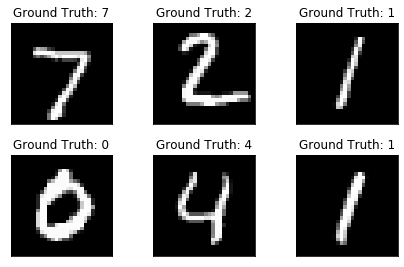

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

### 梯度下降法

In [6]:
def sgd(parameters, lr):
    for param in parameters:
        param.data -= lr * param.grad
        param.grad.data.zero_()

In [7]:
loss_sgd = nn.CrossEntropyLoss()

In [8]:
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [10]:
# 初始化梯度平方项
s = []
for param in net.parameters():
    s.append(torch.zeros_like(param.data))

# 开始训练
losses0 = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for img, label in train_loader:
        #展平img
        img=img.view(img.size(0),-1)
        # 前向传播
        out = net(img)
        loss = loss_sgd(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd(net.parameters(),1e-2)
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:
            losses0.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'.format(e, train_loss / len(train_loader)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 1.024128
epoch: 1, Train Loss: 0.454307
epoch: 2, Train Loss: 0.378152
epoch: 3, Train Loss: 0.344539
epoch: 4, Train Loss: 0.322860
使用时间: 45.77255 s


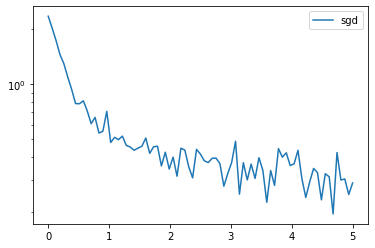

In [11]:
x_axis = np.linspace(0, 5, len(losses0), endpoint=True)
plt.semilogy(x_axis, losses0, label='sgd')
plt.legend(loc='best')

### 动量梯度下降法
$$ v_i = \gamma v_{i-1} + \eta \nabla L(\theta)$$

$$ \theta_i = \theta_{i-1} - v_i$$
其中 $v_i$ 是当前速度，$\gamma$ 是动量参数，是一个小于 1的正数，$\eta$ 是学习率。

相当于每次在进行参数更新的时候，都会将之前的速度考虑进来，每个参数在各方向上的移动幅度不仅取决于当前的梯度，还取决于过去各个梯度在各个方向上是否一致，如果一个梯度一直沿着当前方向进行更新，那么每次更新的幅度就越来越大，如果一个梯度在一个方向上不断变化，那么其更新幅度就会被衰减，这样我们就可以使用一个较大的学习率，使得收敛更快，同时梯度比较大的方向就会因为动量的关系每次更新的幅度减少。

比如我们的梯度每次都等于 g，而且方向都相同，那么动量法在该方向上使参数加速移动，有下面的公式：

$$ v_0 = 0 $$
$$ v_1 = \gamma v_0 + \eta g = \eta g $$
$$ v_2 = \gamma v_1 + \eta g = (1 + \gamma) \eta g $$
$$ v_3 = \gamma v_2 + \eta g = (1 + \gamma + \gamma^2) \eta g $$
$$ \cdots $$
$$ v_{+ \infty} = (1 + \gamma + \gamma^2 + \gamma^3 + \cdots) \eta g = \frac{1}{1 - \gamma} \eta g $$

如果我们把 $\gamma$ 定为 0.9，那么更新幅度的峰值就是原本梯度乘学习率的 10 倍。
动量项会沿着梯度指向方向相同的方向不断增大，对于梯度方向改变的方向逐渐减小，得到了更快的收敛速度以及更小的震荡

In [12]:
def sgd_momentum(parameters, vs, lr, gamma):
    for param, v in zip(parameters, vs):
        v[:] = gamma * v + lr * param.grad
        param.data -= v
        param.grad.data.zero_()

In [13]:
loss_sgd_mom = nn.CrossEntropyLoss()

In [14]:
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [16]:
# 初始化梯度平方项
vs = []
for param in net.parameters():
    vs.append(torch.zeros_like(param.data))

# 开始训练
losses1 = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for img, label in train_loader:
        #展平img
        img=img.view(img.size(0),-1)
        # 前向传播
        out = net(img)
        loss = loss_sgd_mom(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_momentum(net.parameters(), vs, 1e-2, 0.9)
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:
            losses1.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'.format(e, train_loss / len(train_loader)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.452276
epoch: 1, Train Loss: 0.238801
epoch: 2, Train Loss: 0.176478
epoch: 3, Train Loss: 0.141717
epoch: 4, Train Loss: 0.119639
使用时间: 45.43953 s


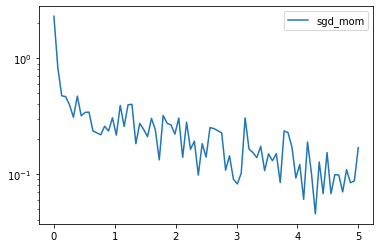

In [17]:
x_axis = np.linspace(0, 5, len(losses1), endpoint=True)
plt.semilogy(x_axis, losses1, label='sgd_mom')
plt.legend(loc='best')

### 比较这两种方法

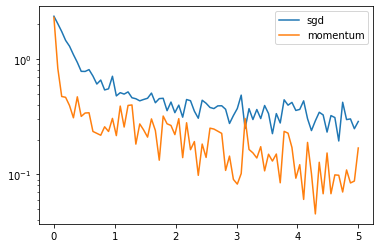

In [18]:
x_axis = np.linspace(0, 5, len(losses0), endpoint=True)
plt.semilogy(x_axis, losses0, label='sgd')
plt.semilogy(x_axis, losses1, label='momentum')
plt.legend(loc='best')

## <font color = blue>本代码块（pytorch-05-04.ipynb）以下为参考内容</font>

### Adagrad算法
Adagrad 的想法非常简答，在每次使用一个 batch size 的数据进行参数更新的时候，我们需要计算所有参数的梯度，那么其想法就是对于每个参数，初始化一个变量 s 为 0，然后每次将该参数的梯度平方求和累加到这个变量 s 上，然后在更新这个参数的时候，学习率就变为
$$ \frac{\eta}{\sqrt{s + \epsilon}}$$
这里的 $\epsilon$ 是为了数值稳定性而加上的，因为有可能 s 的值为 0

Adagrad 的核心想法就是，如果一个参数的梯度一直都非常大，那么其对应的学习率就变小一点，防止震荡，而一个参数的梯度一直都非常小，那么这个参数的学习率就变大一点，使得其能够更快地更新
Adagrad 也有一些问题，因为 s 不断累加梯度的平方，所以会越来越大，导致学习率在后期会变得较小，导致收敛乏力的情况，可能无法收敛到表较好的结果，当然后面有一个对其的改进，我们之后会讲到

In [32]:
def sgd_adagrad(parameters, s, lr):
    eps = 1e-10
    for param, s in zip(parameters, s):
        s[:] = s + (param.grad) ** 2
        div = lr / torch.sqrt(s + eps) * param.grad
        param.data = param.data - div
        param.grad.data.zero_()

这有两个好处：首先，我们不再需要决定梯度何时算足够大。 其次，它会随梯度的大小自动变化。通常对应于较大梯度的坐标会显著缩小，而其他梯度较小的坐标则会得到更平滑的处理。

In [33]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [34]:
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

In [35]:
loss_adagrad = nn.CrossEntropyLoss()

In [36]:
# 初始化梯度平方项
s = []
for param in net.parameters():
    s.append(torch.zeros_like(param.data))

# 开始训练
losses2 = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for img, label in train_loader:
        #展平img
        img=img.view(img.size(0),-1)
        # 前向传播
        out = net(img)
        loss = loss_adagrad(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_adagrad(net.parameters(), s, 1e-2)
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:
            losses2.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'.format(e, train_loss / len(train_loader)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.402102
epoch: 1, Train Loss: 0.246097
epoch: 2, Train Loss: 0.207577
epoch: 3, Train Loss: 0.183913
epoch: 4, Train Loss: 0.167918
使用时间: 48.77689 s


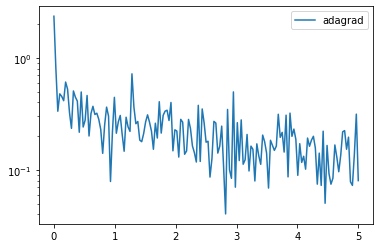

In [37]:
x_axis = np.linspace(0, 5, len(losses2), endpoint=True)
plt.semilogy(x_axis, losses2, label='adagrad')
plt.legend(loc='best')

可以看到，使用自适应的学习率跑 5 个 epoch 可以得到比随机梯度下降得到更小的 loss，学习率能够自适应地降低，所以能够有更好的效果。
当然 pytorch 也内置了 adagrad 的优化算法，只需要调用 torch.optim.Adagrad()，下面是例子。

## 使用简洁方法实现

In [38]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [39]:
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

In [40]:
optimizer = torch.optim.Adagrad(net.parameters(), lr=1e-2)
loss_cnt = nn.CrossEntropyLoss()

In [41]:
# 开始训练
losses3 = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for img, label in train_loader:
        #展平img
        img=img.view(img.size(0),-1)
        # 前向传播
        out = net(img)
        loss = loss_cnt(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:
            losses3.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'.format(e, train_loss / len(train_loader)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.395281
epoch: 1, Train Loss: 0.245230
epoch: 2, Train Loss: 0.205823
epoch: 3, Train Loss: 0.181532
epoch: 4, Train Loss: 0.165350
使用时间: 46.71178 s


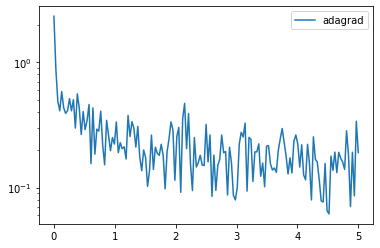

In [42]:
x_axis = np.linspace(0, 5, len(losses3), endpoint=True)
plt.semilogy(x_axis, losses3, label='adagrad')
plt.legend(loc='best')

## RMSProp算法
RMSprop 是由 Geoff Hinton 在他 Coursera 课程中提出的一种适应性学习率方法，至今仍未被公开发表。前面我们提到了 Adagrad 算法有一个问题，就是学习率分母上的变量 s 不断被累加增大，最后会导致学习率除以一个比较大的数之后变得非常小，这不利于我们找到最后的最优解，所以 RMSProp 的提出就是为了解决这个问题。

Adagrad算法将梯度 gt 的平方累加成状态矢量 $s_t=s_{t−1}+g^2_t$。 因此，由于缺乏规范化，没有约束力， st 持续增长，几乎上是在算法收敛时呈线性递增。

解决此问题的一种方法是使用 $s_t/t$ 。 对于$g_t$的合理分布来说，它将收敛。 遗憾的是，限制行为生效可能需要很长时间，因为该流程记住了价值的完整轨迹。 另一种方法是按动量法中的方式使用移动平均值，即 $s_t←γs_{t−1}+(1−γ)g^2_t$，其中参数 γ>0 。 保持其他部所有分不变就产生了RMSProp算法。

RMSProp 仍然会使用梯度的平方量，不同于 Adagrad，其会使用一个指数加权移动平均来计算这个 s，也就是

$$ s_i = \alpha s_{i-1} + (1 - \alpha) \ g^2$$

这里 g 表示当前求出的参数梯度，然后最终更新和 Adagrad 是一样的，学习率变成了

$$ \frac{\eta}{\sqrt{s + \epsilon}}$$

这里 $\alpha$ 是一个移动平均的系数，也是因为这个系数，导致了 RMSProp 和 Adagrad 不同的地方，这个系数使得 RMSProp 更新到后期累加的梯度平方较小，从而保证 s 不会太大，也就使得模型后期依然能够找到比较优的结果

In [46]:
def rmsprop(parameters, s, lr, alpha):
    eps = 1e-10
    for param, sqr in zip(parameters, s):
        sqr[:] = alpha * sqr + (1 - alpha) * param.grad ** 2
        div = lr / torch.sqrt(sqr + eps) * param.grad
        param.data = param.data - div
        param.grad.data.zero_()

In [47]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [48]:
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

In [49]:
loss_rmsprop = nn.CrossEntropyLoss()

In [50]:
# 初始化梯度平方项
s = []
for param in net.parameters():
    s.append(torch.zeros_like(param.data))

# 开始训练
losses4 = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for img, label in train_loader:
        #展平img
        img=img.view(img.size(0),-1)
        # 前向传播
        out = net(img)
        loss = loss_rmsprop(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        rmsprop(net.parameters(), s, 1e-3, 0.9) # 学习率设为 0.001，alpha 设为 0.9
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:
            losses4.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'.format(e, train_loss / len(train_loader)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.369642
epoch: 1, Train Loss: 0.167480
epoch: 2, Train Loss: 0.123965
epoch: 3, Train Loss: 0.102790
epoch: 4, Train Loss: 0.088754
使用时间: 49.97310 s


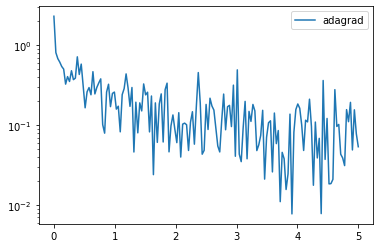

In [51]:
x_axis = np.linspace(0, 5, len(losses4), endpoint=True)
plt.semilogy(x_axis, losses4, label='adagrad')
plt.legend(loc='best')

RMSProp算法与Adagrad算法非常相似，因为两者都使用梯度的平方来缩放系数。
RMSProp算法与动量法都使用移动平均值。但是，RMSProp算法使用该技术来调整按系数顺序的预处理器

## Adadelta 算法
Adadelta 算是 Adagrad 法的延伸，它跟 RMSProp 一样，都是为了解决 Adagrad 中学习率不断减小的问题，RMSProp 是通过移动加权平均的方式，而 Adadelta 也是一种方法，有趣的是，它并不需要学习率这个参数。

Adadelta使用两个状态变量， st 用于存储梯度二阶导数的移动加权平均值， Δxt 用于存储模型本身中参数变化二阶导数的移动加权平均值

Adadelta 跟 RMSProp 一样，先使用移动平均来计算 s

$$ s = \rho s + (1 - \rho) g^2 $$

这里 $\rho$ 和 RMSProp 中的 $\alpha$ 都是移动平均系数，g 是参数的梯度，然后我们会计算需要更新的参数的变化量

$$ g' = \frac{\sqrt{\Delta \theta + \epsilon}}{\sqrt{s + \epsilon}} g $$

$\Delta \theta$ 初始为 0 张量，每一步做如下的指数加权移动平均更新

$$ \Delta \theta = \rho \Delta \theta + (1 - \rho) g'^2 $$

最后参数更新如下

$$ \theta = \theta - g'$$

In [52]:
def adadelta(parameters, s, deltas, rho):
    eps = 1e-6
    for param, sqr, delta in zip(parameters, s, deltas):
        sqr[:] = rho * sqr + (1 - rho) * param.grad ** 2
        cur_delta = torch.sqrt(delta + eps) / torch.sqrt(sqr + eps) * param.grad
        delta[:] = rho * delta + (1 - rho) * cur_delta ** 2
        param.data = param.data - cur_delta
        param.grad.data.zero_()

In [53]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [54]:
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

In [55]:
loss_adadelta = nn.CrossEntropyLoss()

In [56]:
# 初始化梯度平方项
s = []
deltas = []
for param in net.parameters():
    s.append(torch.zeros_like(param.data))
    deltas.append(torch.zeros_like(param.data))

# 开始训练
losses6 = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for img, label in train_loader:
        #展平img
        img=img.view(img.size(0),-1)
        # 前向传播
        out = net(img)
        loss = loss_adadelta(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        adadelta(net.parameters(), s, deltas, 0.9) # rho 设置为 0.9
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:
            losses6.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'.format(e, train_loss / len(train_loader)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.360622
epoch: 1, Train Loss: 0.159509
epoch: 2, Train Loss: 0.120988
epoch: 3, Train Loss: 0.102545
epoch: 4, Train Loss: 0.089021
使用时间: 53.04489 s


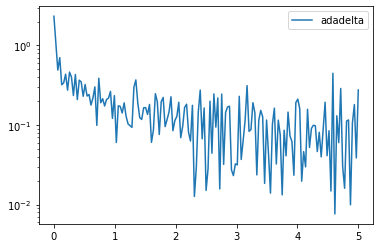

In [57]:
x_axis = np.linspace(0, 5, len(losses6), endpoint=True)
plt.semilogy(x_axis, losses6, label='adadelta')
plt.legend(loc='best')

Adadelta没有学习率参数。相反，它使用参数本身的变化率来调整学习率。
Adadelta需要两个状态变量来存储梯度的二阶导数和参数的变化

## Adam 算法
Adam算法是一个结合了动量法和 RMSProp 的优化算法，其结合了两者的优点

Adam 算法会使用一个动量变量 v 和一个 RMSProp 中的梯度元素平方的移动指数加权平均 s，首先将他们全部初始化为 0，然后在每次迭代中，计算他们的移动加权平均进行更新

$$ v = \beta_1 v + (1 - \beta_1) g \ s = \beta_2 s + (1 - \beta_2) g^2 $$

在 adam 算法里，为了减轻 v 和 s 被初始化为 0 的初期对计算指数加权移动平均的影响，每次 v 和 s 都做下面的修正

$$ \hat{v} = \frac{v}{1 - \beta_1^t} \ \hat{s} = \frac{s}{1 - \beta_2^t}$$

这里 t 是迭代次数，可以看到，当 $0 \leq \beta_1, \beta_2 \leq 1$ 的时候，迭代到后期 t 比较大，那么 $\beta_1^t$ 和 $\beta_2^t$ 就几乎为 0，就不会对 v 和 s 有任何影响了，算法作者建议$\beta_1 = 0.9$, $\beta_2 = 0.999$。

最后使用修正之后的 $\hat{v}$ 和 $\hat{s}$ 进行学习率的重新计算

$$ g' = \frac{\eta \hat{v}}{\sqrt{\hat{s}} + \epsilon}$$

与RMSProp不同，我们的更新使用动量 $v^t$ 而不是梯度本身。 此外，由于使用$\frac 1{\sqrt{\hat{s}} + \epsilon}$而不是 $\frac 1{\sqrt{\hat{s} + \epsilon}}$进行缩放，两者会略有差异。 前者在实践中效果略好一些，因此与RMSProp算法有所区分。
这里 $\eta$ 是学习率，$epsilon$ 仍然是为了数值稳定性而添加的常数，最后参数更新有

$$ \theta_i = \theta_{i-1} - g'$$

下面我们来实现以下 adam 算法

In [58]:
def adam(parameters, vs, s, lr, t, beta1=0.9, beta2=0.999):
    eps = 1e-8
    for param, v, sqr in zip(parameters, vs, s):
        v[:] = beta1 * v + (1 - beta1) * param.grad
        sqr[:] = beta2 * sqr + (1 - beta2) * param.grad ** 2
        v_hat = v / (1 - beta1 ** t)
        s_hat = sqr / (1 - beta2 ** t)
        param.data = param.data - lr * v_hat / (torch.sqrt(s_hat) + eps)
        param.grad.data.zero_()

In [59]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [60]:
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

In [61]:
loss_cnt = nn.CrossEntropyLoss()

In [62]:
# 初始化梯度平方项
s = []
vs = []
for param in net.parameters():
    s.append(torch.zeros_like(param.data))
    vs.append(torch.zeros_like(param.data))
    

t = 1

# 开始训练
losses6 = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for img, label in train_loader:
        #展平img
        img=img.view(img.size(0),-1)
        # 前向传播
        out = net(img)
        loss = loss_cnt(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        adam(net.parameters(), vs, s, 1e-3, t) # 学习率设为 0.001
        t += 1
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:
            losses6.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'.format(e, train_loss / len(train_loader)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.352930
epoch: 1, Train Loss: 0.167723
epoch: 2, Train Loss: 0.120161
epoch: 3, Train Loss: 0.097370
epoch: 4, Train Loss: 0.082802
使用时间: 53.32414 s


可以看到使用 adam 算法 loss 能够更快更好地收敛，但是一定要小心学习率的设定，使用自适应的算法一般需要更小的学习率

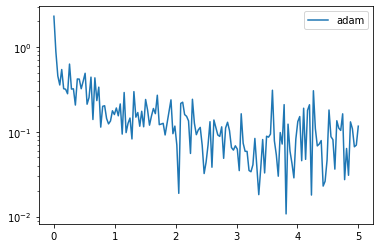

In [63]:
x_axis = np.linspace(0, 5, len(losses6), endpoint=True)
plt.semilogy(x_axis, losses6, label='adam')
plt.legend(loc='best')

可以看到使用 adam 算法 loss 能够更快更好地收敛，但是一定要小心学习率的设定，使用自适应的算法一般需要更小的学习率

## Yogi 算法
Adam算法也存在一些问题： 即使在凸环境下，当$s_t$ 的第二力矩估计值爆炸时，它可能无法收敛。

In [64]:
def yogi(parameters, vs, s, lr, t, beta1=0.9, beta2=0.999):
    eps = 1e-8
    for param, v, sqr in zip(parameters, vs, s):
        v[:] = beta1 * v + (1 - beta1) * param.grad
        #sqr[:] = beta2 * sqr + (1 - beta2) * param.grad ** 2
        sqr[:] = sqr + (1 - beta2) * torch.sign(torch.square(param.grad) - sqr) * torch.square(param.grad)
        v_hat = v / (1 - beta1 ** t)
        s_hat = sqr / (1 - beta2 ** t)
        param.data = param.data - lr * v_hat / (torch.sqrt(s_hat) + eps)
        param.grad.data.zero_()

In [65]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [66]:
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

In [67]:
loss_cnt = nn.CrossEntropyLoss()

In [68]:
# 初始化梯度平方项
s = []
vs = []
for param in net.parameters():
    s.append(torch.zeros_like(param.data))
    vs.append(torch.zeros_like(param.data))
    

t = 1

# 开始训练
losses7 = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for img, label in train_loader:
        #展平img
        img=img.view(img.size(0),-1)
        # 前向传播
        out = net(img)
        loss = loss_cnt(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        yogi(net.parameters(), vs, s, 1e-3, t) # 学习率设为 0.001
        t += 1
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:
            losses7.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'.format(e, train_loss / len(train_loader)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.410235
epoch: 1, Train Loss: 0.216382
epoch: 2, Train Loss: 0.156282
epoch: 3, Train Loss: 0.122416
epoch: 4, Train Loss: 0.100358
使用时间: 48.98595 s


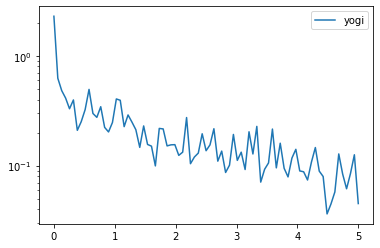

In [69]:
x_axis = np.linspace(0, 5, len(losses7), endpoint=True)
plt.semilogy(x_axis, losses7, label='yogi')
plt.legend(loc='best')

对于具有显著差异的梯度，我们可能会遇到收敛性问题。我们可以通过使用更大的小批量或者切换到改进的估计值 st 来修正它们。Yogi提供了这样的替代方案。